# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Juanwen Zhang
*   Student Number: 1002247017

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? ___284807__ **[0.1]**
* What features in the dataset are present aside from the 28 main features?  __amount___ **[0.1]**
* Which column contains the targets? column name "Class" **[0.1]**
* To what do the target values correspond?__ the transaction is a fraud or not___ **[0.1]**

In [1]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=b3fa56fe66cb6255523ce399e6263d2ff5eb4e982d9b5c8992e19f7eb8bdd246
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [3]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [5]:
df.tail(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284797,172782.0,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,-0.612982,-0.066655,-0.732987,0.237948,-0.293959,-0.245496,-0.174846,-0.891169,-0.290491,-0.139512,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,5.49,0
284798,172782.0,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,-1.109232,-0.453235,-1.046946,1.122674,1.243518,-1.431897,0.939328,-0.002373,2.894952,0.006666,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,24.05,0
284799,172783.0,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,-1.264072,0.453596,-0.243142,-0.858719,-0.766554,-0.644646,0.447184,0.388721,0.792135,0.348176,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,79.99,0
284800,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,0.523316,0.559047,-0.834660,0.626211,-0.541494,0.225361,-0.605252,-0.163049,0.561695,-0.256922,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0
284801,172785.0,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,0.644837,0.190916,-0.546329,-0.731707,-0.808036,0.599628,0.070441,0.373110,0.128904,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69,0
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
print(len(df))

284807



* What is the percentage of entries in the dataset for each class? _____ **[0.1]**
* Is this data considered balanced or unbalanced? Why is this the case?_____ **[0.1]**
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? _____ **[0.2]**



In [7]:
fraud=len(df[df['Class'] == 1])
all=len(df)
percentage_fraud = fraud/all
print(str(percentage_fraud *100) + "%")
print(str(100-(percentage_fraud *100)) + "%")

0.1727485630620034%
99.827251436938%


The dataset is unbalanced. Because the target variable of 0 (non-fraudulent)has way more observations than the other calss (fraudulent). 

Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [8]:
!pip install fast_ml --upgrade

     |████████████████████████████████| 42 kB 365 kB/s 


In [9]:
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(df, target = 'Class', train_size=0.7, valid_size=0.15, test_size=0.15, random_state=0)


Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

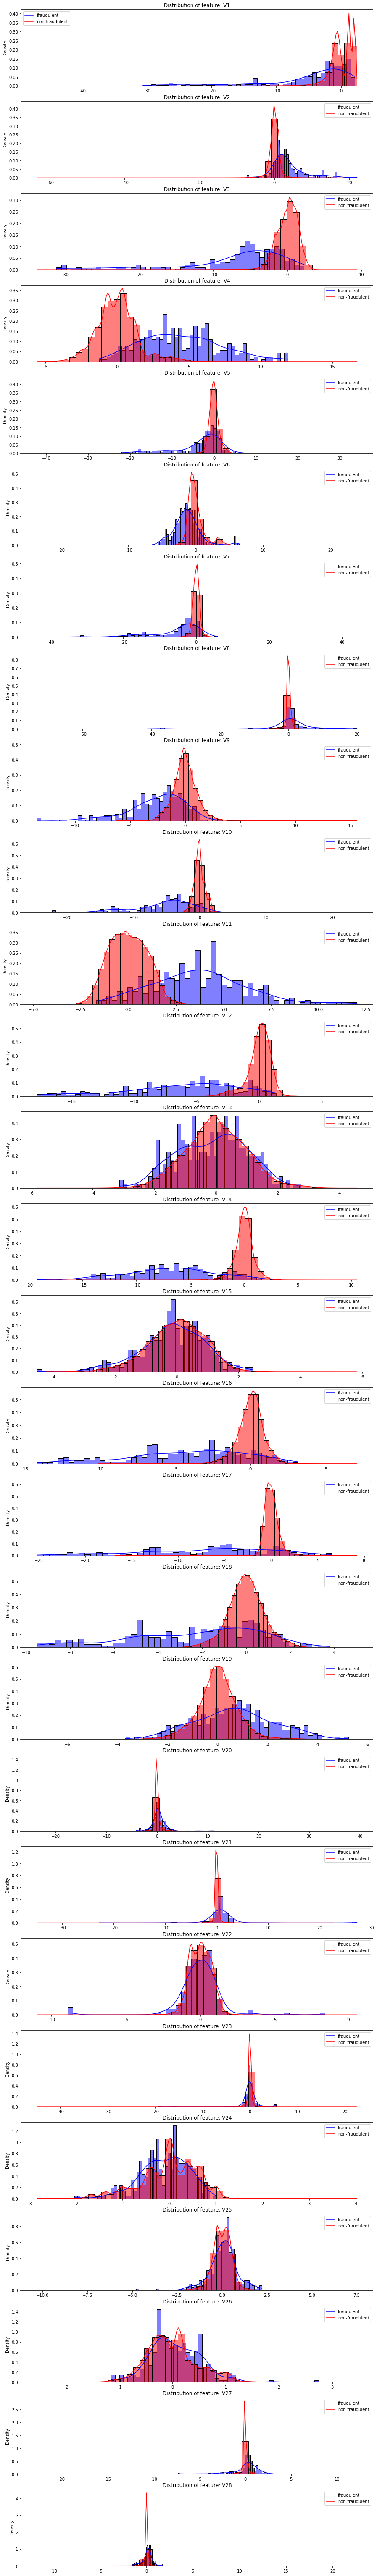

In [10]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

The graphs indicate that there are a certain number of Gaussian distributions for some features. Some may fit single Gaussian model and some may fit two-Gaussian model. And each of these distributions represent a cluster. Thus, a single Gaussian model cannot explain the dataset well in anomaly detection. Gaussian model with multiple component can be considered in order to have a better performance on detecting anomaly. 

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





In [ ]:
# fit a single Gaussian model on 1 feature on training set
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
score=[]
auc_list = []
for i in range(1, 29):
  gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
  v_data_train=X_train.iloc[:,i].values.reshape(-1,1)
  gm.fit(v_data_train)
  c = gm.score_samples(v_data_train)
  score.append(c)
  fpr_gm, tpr_gm, threshold_train = roc_curve(y_train, 1-c)
  auc_v = auc(fpr_gm, tpr_gm)
  auc_list.append(auc_v)
auc_df = pd.DataFrame(auc_list)

# print AUC on training set
auc_df.columns =["Training_AUC"]
print(auc_df)

In [62]:
# calculate AUC on validation set
score_val=[]
auc_val_list = []
for i in range(1, 29):
  gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
  v_data_val=X_val.iloc[:,i].values.reshape(-1,1)
  gm.fit(v_data_val)
  sc = gm.score_samples(v_data_val)
  score_val.append(sc)
  fpr_gm2, tpr_gm2, threshold_val = roc_curve(y_val, 1-sc) #for each data, compare 1-sc with class in the validation set"
  auc_v_val = auc(fpr_gm2, tpr_gm2)
  auc_val_list.append(auc_v_val)
auc_val_df = pd.DataFrame(auc_val_list)
auc_val_df.columns =["Validation_AUC"]

table1= pd.concat([auc_df, auc_val_df], axis = 1 )
print(table1)

    Training_AUC  Validation_AUC
0       0.705102        0.694818
1       0.837499        0.837433
2       0.876537        0.839276
3       0.892103        0.888610
4       0.771825        0.786709
5       0.734380        0.673080
6       0.862967        0.867483
7       0.773238        0.774046
8       0.802874        0.777119
9       0.913600        0.905961
10      0.897175        0.881981
11      0.920180        0.838776
12      0.572152        0.561934
13      0.952459        0.938092
14      0.514764        0.509243
15      0.902137        0.882755
16      0.934852        0.881756
17      0.808030        0.785707
18      0.741874        0.770665
19      0.734692        0.686446
20      0.833521        0.764480
21      0.561287        0.493498
22      0.696326        0.662137
23      0.469229        0.498029
24      0.574918        0.521370
25      0.503272        0.517017
26      0.835479        0.766196
27      0.814201        0.794934


In [63]:
print(auc_val_df.sort_values(["Validation_AUC"], ascending=[False]).head(3))

    Validation_AUC
13        0.938092
9         0.905961
3         0.888610


In [71]:
#5
df_3_v = pd.DataFrame({"V14": X_val.iloc[:,14], "V10": X_val.iloc[:,10], "V4": X_val.iloc[:,4]})
score_3v = []
for i in range(0, 3):
  gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
  v_feature = df_3_v.iloc[:,i].values.reshape(-1,1)
  gm.fit(v_feature)
  sc_3v = gm.score_samples(v_feature)
  score_3v.append(sc_3v)
print(score_3v)

[array([-1.42497315, -0.86675832, -0.87101572, ..., -1.0007124 ,
       -1.14453566, -1.0348083 ]), array([-2.05500213, -0.99833423, -1.17898851, ..., -0.99470427,
       -1.0549046 , -1.11847713]), array([-1.88866771, -1.28874581, -1.74951214, ..., -1.32467624,
       -1.50669913, -3.79254876])]


In [ ]:
threshhold = np.sort(score_3v[0])

In [83]:
from sklearn.metrics import f1_score
F1_v14_list = []
threshold_list_V14 = []
for z in range(1, 500, 50):
  thresharray = np.sort(score_3v[0])
  list_thresh = list(thresharray)
  threshold = list_thresh[z]
  F1_v14 = f1_score(y_val, score_3v[0]< threshold)
  F1_v14_list.append(F1_v14) 
  threshold_list_V14.append(threshold)
print(F1_v14_list)
print(threshold_list_V14[F1_v14_list.index(max(F1_v14_list))])

[0.029411764705882353, 0.576271186440678, 0.5, 0.44036697247706424, 0.373134328358209, 0.31446540880503143, 0.27717391304347827, 0.24880382775119614, 0.2222222222222222, 0.2007722007722008]
-20.752201446100635


In [86]:
from sklearn.metrics import f1_score
F1_v10_list = []
threshold_v10_list = []
for z in range(1, 500, 50):
  thresharray = np.sort(score_3v[1])
  list_thresh = list(thresharray)
  threshold = list_thresh[z]
  F1_v10 = f1_score(y_val, score_3v[1]< threshold)
  F1_v10_list.append(F1_v10) 
  threshold_v10_list.append(threshold)
print(F1_v10_list)
print(threshold_v10_list[F1_v10_list.index(max(F1_v10_list))])

[0.029411764705882353, 0.20338983050847456, 0.15476190476190477, 0.13761467889908258, 0.1492537313432836, 0.14465408805031446, 0.14130434782608695, 0.1291866028708134, 0.1452991452991453, 0.138996138996139]
-40.87328351186561


In [89]:
from sklearn.metrics import f1_score
F1_v4_list = []
threshold_v4_list = []
for z in range(1, 400, 40):
  thresharray = np.sort(score_3v[2])
  list_thresh = list(thresharray)
  threshold = list_thresh[z]
  F1_v4 = f1_score(y_val, score_3v[2]< threshold)
  F1_v4_list.append(F1_v4) 
  threshold_v4_list.append(threshold)
print(F1_v4_list)
print(threshold_v4_list[F1_v4_list.index(max(F1_v4_list))])

[0.0, 0.35185185185185186, 0.33783783783783783, 0.26595744680851063, 0.21929824561403508, 0.19402985074626866, 0.16883116883116883, 0.14942528735632182, 0.13402061855670103, 0.12149532710280375]
-10.85653554662516


6. Complexity of my method for determing the optimal threshold is O(nlogn).

In [22]:
#Part b. Pick three features with highest AUC.
table_a = pd.DataFrame({'V1' : [max(F1_v14_list),auc_val_df["Validation_AUC"][13]],
                        'V2' : [max(F1_v10_list), auc_val_df["Validation_AUC"][9]],
                        'V3' : [max(F1_v4_list), auc_val_df["Validation_AUC"][3]]},
                       index=['F1 part a', 'AUC part a'])
table_a                             

,V1,V2,V3
F1 part a,0.590164,0.255814,0.356436
AUC part a,0.938092,0.905961,0.888610


In [91]:
#compute AUC only on non-fraudulent data
training_set = pd.concat([X_train, y_train], axis=1)
training_set_0 = training_set[training_set['Class']==0]
df_3v_0 = pd.DataFrame({"V14": training_set_0.iloc[:,14], "V10": training_set_0.iloc[:,10], "V4": training_set_0.iloc[:,4]})
df_3v_b = pd.DataFrame({"V14": training_set.iloc[:,14], "V10": training_set.iloc[:,10], "V4": training_set.iloc[:,4]})

score_b=[]
auc_3v_b_list = []
for i in range(0,3):
  gm_0 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )
  train_3v_0 = df_3v_0.iloc[:,i].values.reshape(-1,1)
  train_3v_b = df_3v_b.iloc[:,i].values.reshape(-1,1)
  gm_0.fit(train_3v_0)
  sc = gm_0.score_samples(train_3v_b)
  score_b.append(sc)
  fpr_gm, tpr_gm, thre = roc_curve(y_train, 1-sc)
  auc_3v_b = auc(fpr_gm, tpr_gm)
  auc_3v_b_list.append(auc_3v_b)
auc_3v_b_df = pd.DataFrame(auc_3v_b_list)
print(auc_3v_b_df)

          0
0  0.952599
1  0.913558
2  0.892612


In [26]:
#compute F1 only on non-fraudulent data on those three features
from sklearn.metrics import f1_score
F1_v14b_list = []
new_thre_v14_list = []
sc_14 = gm_0.score_samples(df_3v_b.iloc[:,0].values.reshape(-1,1))
for i in range(200, 600, 40):
  thresh_14b = sorted(sc_14)[i]
  F1_v14b = f1_score(y_train, sc_14< thresh_14b)
  F1_v14b_list.append(F1_v14b) 
  new_thre_v14_list.append(thresh_14b)
print(F1_v14b_list)
print(new_thre_v14_list[F1_v14b_list.index(max(F1_v14b_list))])

[0.5394495412844036, 0.5709401709401709, 0.5920000000000001, 0.6105263157894737, 0.5929078014184398, 0.5879194630872483, 0.578343949044586, 0.5672727272727273, 0.561849710982659, 0.5524861878453039]
-10.041594683839143


In [27]:
F1_v10b_list = []
new_thre_v10_list = []
sc_10 = gm_0.score_samples(df_3v_b.iloc[:,1].values.reshape(-1,1))
for i in range(400, 800, 40):
  thresh_10b = sorted(sc_10)[i]
  F1_v10b = f1_score(y_train, sc_10< thresh_10b)
  F1_v10b_list.append(F1_v10b) 
  new_thre_v10_list.append(thresh_10b)
print(F1_v10b_list)
print(new_thre_v10_list[F1_v10b_list.index(max(F1_v10b_list))])

[0.19328859060402684, 0.20382165605095542, 0.20363636363636364, 0.20578034682080926, 0.20331491712707184, 0.19682539682539682, 0.19695431472081218, 0.1951219512195122, 0.19342723004694837, 0.19366515837104073]
-15.912113360522756


In [28]:
F1_v4b_list = []
new_thre_v4_list = []
sc_4 = gm_0.score_samples(df_3v_b.iloc[:,2].values.reshape(-1,1))
for i in range(250, 550, 25):
  thresh_4b = sorted(sc_4)[i]
  F1_v4b = f1_score(y_train, sc_4< thresh_4b)
  F1_v4b_list.append(F1_v4b) 
  new_thre_v4_list.append(thresh_4b)
print(F1_v4b_list)
print(new_thre_v4_list[F1_v4b_list.index(max(F1_v4b_list))])

[0.34957983193277314, 0.35806451612903223, 0.3503875968992248, 0.3462686567164179, 0.34820143884892085, 0.3472222222222222, 0.35973154362416104, 0.3558441558441558, 0.3547169811320755, 0.348780487804878, 0.3408284023668639, 0.3310344827586207]
-8.367439650758298


In [92]:
table = pd.DataFrame({'V1' : [max(F1_v14_list),auc_val_df["Validation_AUC"][13], max(F1_v14b_list), auc_3v_b_df[0][0]],
                        'V2' : [max(F1_v10_list), auc_val_df["Validation_AUC"][9], max(F1_v10b_list), auc_3v_b_df[0][1]],
                        'V3' : [max(F1_v4_list), auc_val_df["Validation_AUC"][3], max(F1_v4b_list), auc_3v_b_df[0][2]]},
                       index=['F1 part a', 'AUC part a','F1 part b', 'AUC part b'])
table     

,V1,V2,V3
F1 part a,0.576271,0.203390,0.351852
AUC part a,0.938092,0.905961,0.888610
F1 part b,0.610526,0.205780,0.359732
AUC part b,0.952599,0.913558,0.892612


The results are similar. Because the sample size of fraudulent transaction is much smaller than the non-fraudulent ones. Although the second model only fit on non-fraudulent transactions, it does not make much difference on the model themselves. Thus, the AUC and F1 scores are similar.

## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





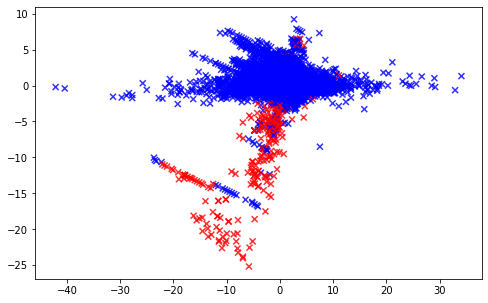

In [30]:
import matplotlib.pyplot as plt
df_train = pd.concat([X_train, y_train], axis=1)
x = df_train["V5"]
y = df_train["V17"]
plt.figure(figsize=(8,5))
plt.scatter(x, y, alpha=0.8, color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')
plt.show()

In [93]:
# Need 2 components Gaussian Model to fit the data
from sklearn.mixture import GaussianMixture
df_2v = pd.concat([df_train["V5"], df_train["V17"]], axis=1)
df_2v_array = df_2v.to_numpy()
gm_2 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
gm_2.fit(df_2v_array)

#auc on training set
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
sc_2v = gm_2.score_samples(df_2v_array)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_train, 1-sc_2v) 
auc_2v = auc(fpr_gm2v, tpr_gm2v)
print(auc_2v)

#auc on validation set
df_2v_val = pd.concat([X_val["V5"], X_val["V17"]], axis=1)
sc_2v_val = gm_2.score_samples(df_2v_val)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_val, 1-sc_2v_val) 
auc_2v_val = auc(fpr_gm2v, tpr_gm2v)
print(auc_2v_val)

0.9336539494335658
0.9085494597626581


In [33]:
# find the threshold that maximize the validation F1 score
F1_pair1_list = []
thresh_pair1_list = []
for i in range(20, 150, 15):
  thresh_pair1 = sorted(sc_2v_val)[i]
  F1_pair1 = f1_score(y_val, sc_2v_val < thresh_pair1)
  F1_pair1_list.append(F1_pair1) 
  thresh_pair1_list.append(thresh_pair1)
print(F1_pair1_list)
print(thresh_pair1_list[F1_pair1_list.index(max(F1_pair1_list))])

[0.3218390804597701, 0.3725490196078431, 0.4444444444444445, 0.42424242424242425, 0.4081632653061225, 0.3950617283950617, 0.37288135593220345, 0.37499999999999994, 0.3671497584541062]
-40.95598604866929


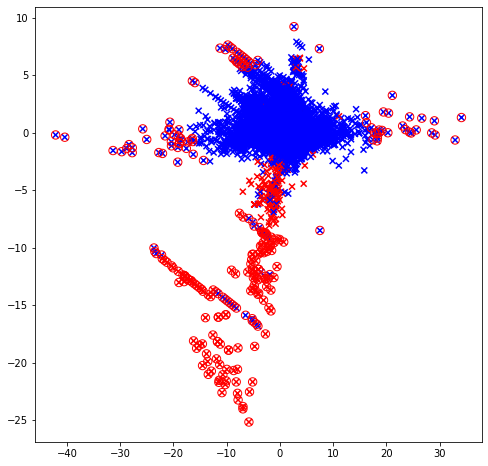

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(df_2v_array[:,0],df_2v_array[:,1],color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')

threshold = -40.95598604866929

outliers = np.nonzero(sc_2v < threshold)[0]
plt.scatter(df_2v_array[outliers,0],df_2v_array[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

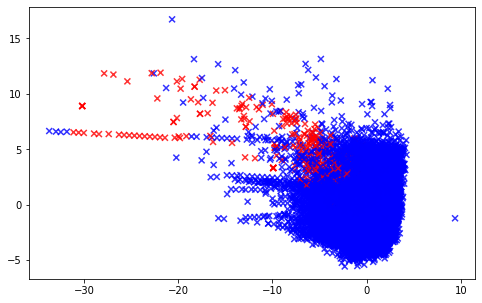

In [35]:
#pick 2nd pair of V features
x = df_train["V3"]
y = df_train["V4"]
plt.figure(figsize=(8,5))
plt.scatter(x, y, alpha=0.8, color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')
plt.show()

In [94]:
#fit Gaussian model(n=1)
from sklearn.mixture import GaussianMixture
df_2v_pair2 = pd.concat([df_train["V3"], df_train["V4"]], axis=1)
df_2v_pair2_array = df_2v_pair2.to_numpy()
gm_2_2 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_2_2.fit(df_2v_pair2_array)

#auc on training set
sc_2v_pair2 = gm_2_2.score_samples(df_2v_pair2_array)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_train, 1-sc_2v_pair2) 
auc_2v_pair2 = auc(fpr_gm2v, tpr_gm2v)
print(auc_2v_pair2)

#auc on validation set
df_val_pair2= pd.concat([X_val["V3"], X_val["V4"]], axis=1)
sc_2v_val = gm_2_2.score_samples(df_val_pair2)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_val, 1-sc_2v_val) 
auc_val_pair2 = auc(fpr_gm2v, tpr_gm2v)
print(auc_val_pair2)

0.9226838221185059
0.9124181455921965


In [107]:
# find threshold
F1_pair2_list = []
thresh_pair2_list = []
for i in range(1, 250, 20):
  thresh_pair2 = sorted(sc_2v_val)[i]
  F1_pair2 = f1_score(y_val, sc_2v_val < thresh_pair2)
  F1_pair2_list.append(F1_pair2) 
  thresh_pair2_list.append(thresh_pair2)
print(F1_pair2_list)
print(thresh_pair2_list[F1_pair2_list.index(max(F1_pair2_list))])

[0.0, 0.29545454545454547, 0.2962962962962963, 0.28125, 0.25675675675675674, 0.29761904761904767, 0.2765957446808511, 0.2692307692307693, 0.26315789473684215, 0.24193548387096775, 0.22388059701492538, 0.20833333333333331, 0.20129870129870128]
-16.241520651225994


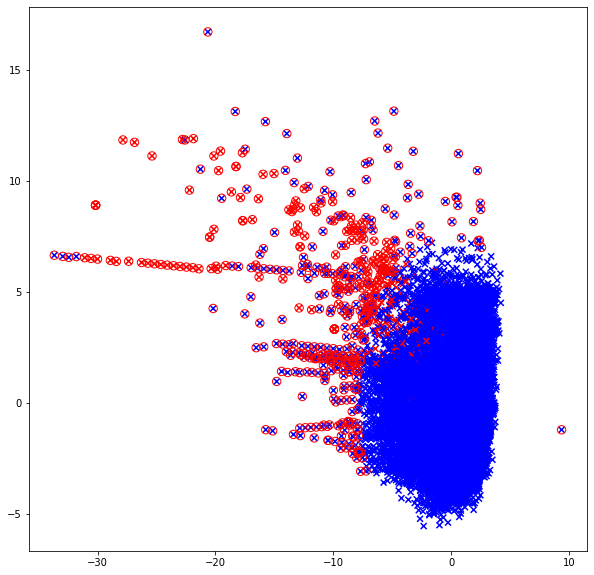

In [108]:
plt.figure(figsize=(10,10))
plt.scatter(df_2v_pair2_array[:,0],df_2v_pair2_array[:,1],color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')

threshold = -16.241520651225994

outliers = np.nonzero(sc_2v_pair2 < threshold)[0]
plt.scatter(df_2v_pair2_array[outliers,0],df_2v_pair2_array[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

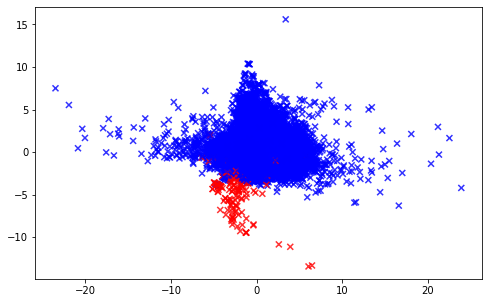

In [39]:
#pick 3rd pair of V features
x = df_train["V6"]
y = df_train["V9"]
plt.figure(figsize=(8,5))
plt.scatter(x, y, alpha=0.8, color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')
plt.show()

In [99]:
#fit Gaussian model(n=1)
from sklearn.mixture import GaussianMixture
df_2v_pair3 = pd.concat([df_train["V6"], df_train["V9"]], axis=1)
gm_2_3 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
gm_2_3.fit(df_2v_pair3)

#auc on training set
sc_2v_pair3 = gm_2_3.score_samples(df_2v_pair3)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_train, 1-sc_2v_pair3) 
auc_2v_pair3 = auc(fpr_gm2v, tpr_gm2v)
print(auc_2v_pair3)

#auc on validation set
df_val_pair3= pd.concat([X_val["V6"], X_val["V9"]], axis=1)
sc_2v_val_pair3 = gm_2_3.score_samples(df_val_pair3)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_val, 1-sc_2v_val_pair3) 
auc_val_pair3 = auc(fpr_gm2v, tpr_gm2v)
print(auc_val_pair3)

0.8149245673215528
0.765558548514986


In [104]:
#find threshold
F1_pair3_list = []
thresh_pair3_list = []
for i in range(100, 250, 15):
  thresh_pair3 = sorted(sc_2v_val_pair3)[i]
  F1_pair3 = f1_score(y_val, sc_2v_val_pair3 < thresh_pair3)
  F1_pair3_list.append(F1_pair3) 
  thresh_pair3_list.append(thresh_pair3)
print(F1_pair3_list)
print(thresh_pair3_list[F1_pair3_list.index(max(F1_pair3_list))])

[0.08383233532934133, 0.0879120879120879, 0.08121827411167512, 0.08490566037735849, 0.07929515418502203, 0.09090909090909091, 0.10116731517509729, 0.09558823529411765, 0.09756097560975607, 0.09271523178807946]
-12.66740562485495


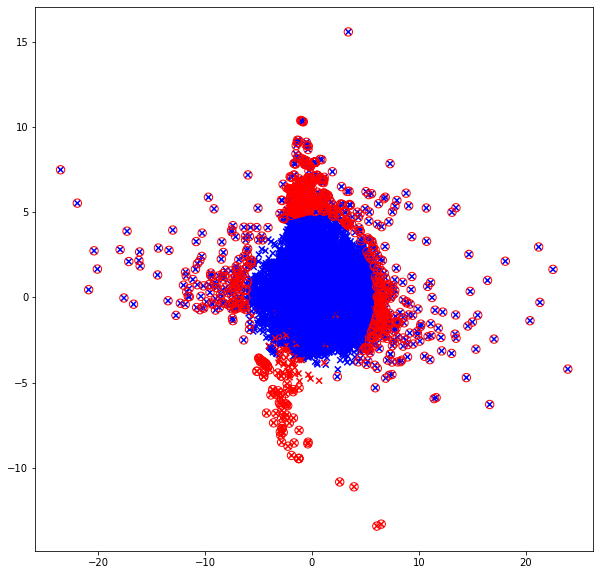

In [105]:
df_2v_pair3_array = df_2v_pair3.to_numpy()
plt.figure(figsize=(10,10))
plt.scatter(df_2v_pair3_array[:,0],df_2v_pair3_array[:,1],color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')

threshold = -12.66740562485495

outliers = np.nonzero(sc_2v_pair3 < threshold)[0]
plt.scatter(df_2v_pair3_array[outliers,0],df_2v_pair3_array[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

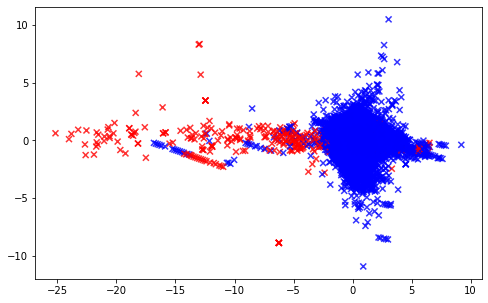

In [43]:
#pick 4th pair of V features
x = df_train["V17"]
y = df_train["V22"]
plt.figure(figsize=(8,5))
plt.scatter(x, y, alpha=0.8, color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')
plt.show()

In [44]:
#fit Gaussian model(n=2)
from sklearn.mixture import GaussianMixture
df_2v_pair4 = pd.concat([df_train["V17"], df_train["V22"]], axis=1)
gm_2_4 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
gm_2_4.fit(df_2v_pair4)

#auc on training set
sc_2v_pair4 = gm_2_4.score_samples(df_2v_pair4)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_train, 1-sc_2v_pair4) 
auc_2v_pair4 = auc(fpr_gm2v, tpr_gm2v)
print(auc_2v_pair4)

#auc on validation set
df_val_pair4= pd.concat([X_val["V6"], X_val["V9"]], axis=1)
sc_2v_val_pair4 = gm_2_4.score_samples(df_val_pair4)
fpr_gm2v, tpr_gm2v, thre_2v = roc_curve(y_val, 1-sc_2v_val_pair4) 
auc_val_pair4 = auc(fpr_gm2v, tpr_gm2v)
print(auc_val_pair4)

0.9338562023537044
0.7669484200883332


In [45]:
#find threshold
F1_pair4_list = []
thresh_pair4_list = []
for i in range(100, 400, 40):
  thresh_pair4 = sorted(sc_2v_val_pair4)[i]
  F1_pair4 = f1_score(y_val, sc_2v_val_pair4 < thresh_pair4)
  F1_pair4_list.append(F1_pair4) 
  thresh_pair4_list.append(thresh_pair4)
print(F1_pair4_list)
print(thresh_pair4_list[F1_pair4_list.index(max(F1_pair4_list))])

[0.08383233532934133, 0.09661835748792269, 0.097165991902834, 0.10452961672473866, 0.09785932721712537, 0.08719346049046323, 0.08353808353808355, 0.0760626398210291]
-11.711839611769271


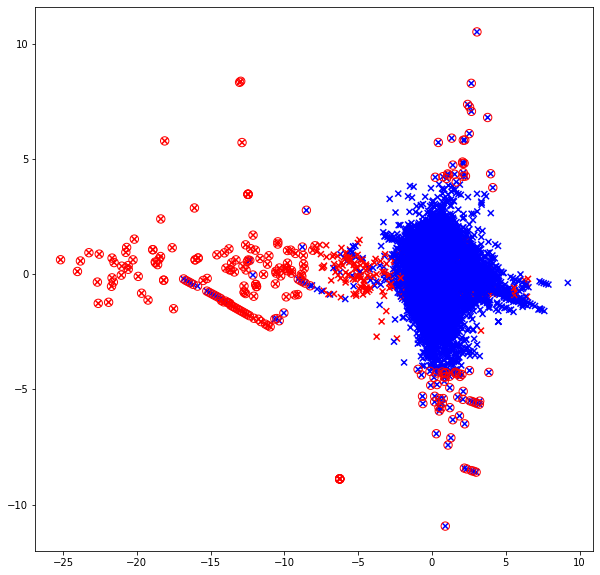

In [46]:
df_2v_pair4_array = df_2v_pair4.to_numpy()
plt.figure(figsize=(10,10))
plt.scatter(df_2v_pair4_array[:,0],df_2v_pair4_array[:,1],color= ['blue' if i == 0 else 'red' for i in df_train["Class"]], marker='x')

threshold = -11.711839611769271

outliers = np.nonzero(sc_2v_pair4 < threshold)[0]
plt.scatter(df_2v_pair4_array[outliers,0],df_2v_pair4_array[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

In [47]:
training_set_0 = training_set[training_set['Class']==0]
train_v17_0 = training_set_0.iloc[:,17].values.reshape(-1,1)
from sklearn.mixture import GaussianMixture
G = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1 = G.fit(train_v17_0)

training_set_1 = training_set[training_set['Class']==1]
train_v17_1 = training_set_1.iloc[:,17].values.reshape(-1,1)
from sklearn.mixture import GaussianMixture
G = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2 = G.fit(train_v17_1)


In [48]:
v17_val=X_val.iloc[:,17].values.reshape(-1,1)
S1= G1.score_samples(v17_val)

S2= G2.score_samples(v17_val)

print(S1)
print(S2)

[-0.75397206 -0.9869693  -1.51344086 ... -0.72774475 -0.80386611
 -1.13925188]
[-3.37760155 -3.24366807 -3.20002513 ... -3.28219563 -3.38764004
 -3.43458122]


In [49]:
F1_cmodel_list = []
c_list = []
for c in np.arange(0, 10, 0.1):
  F1_cmodel = f1_score(y_val, S1< c*S2)
  c_list.append(c) 
  F1_cmodel_list.append(F1_cmodel)
print(F1_cmodel_list)
print(c_list[F1_cmodel_list.index(max(F1_cmodel_list))])

[0.003131719173600075, 0.003131719173600075, 0.0037861714594789506, 0.007891770011273957, 0.01344364012409514, 0.02310597644967785, 0.03609857688302673, 0.050796812749003994, 0.06376057254391672, 0.07777777777777778, 0.09458128078817733, 0.11387900355871887, 0.13008130081300814, 0.14837712519319937, 0.16695652173913045, 0.18355640535372847, 0.19747899159663865, 0.2196261682242991, 0.23677581863979846, 0.26183844011142066, 0.2874617737003058, 0.3046357615894039, 0.3250883392226148, 0.34716981132075475, 0.3694779116465864, 0.38818565400843885, 0.39647577092511016, 0.410958904109589, 0.4265402843601896, 0.43902439024390244, 0.4444444444444444, 0.4705882352941177, 0.5086705202312138, 0.5238095238095238, 0.5217391304347827, 0.525, 0.535031847133758, 0.5599999999999999, 0.5714285714285715, 0.5694444444444444, 0.5755395683453237, 0.5797101449275361, 0.583941605839416, 0.583941605839416, 0.5629629629629629, 0.5801526717557253, 0.5846153846153845, 0.5891472868217054, 0.5984251968503937, 0.608, 

In [50]:
# find c and max F1 score on validation set
training_set_0 = training_set[training_set['Class']==0]
training_set_1 = training_set[training_set['Class']==1]

allfeature_f1training = []
allfeature_f1val = []
c_allfeature = []
for i in range(1, 28):
  train_vi_0 = training_set_0.iloc[:,i].values.reshape(-1,1)
  G = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
  G1 = G.fit(train_vi_0)
  train_vi_1 = training_set_1.iloc[:,i].values.reshape(-1,1)
  G = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
  G2 = G.fit(train_vi_1)

  vi_val=X_val.iloc[:,1].values.reshape(-1,1)
  S1= G1.score_samples(vi_val)
  S2= G2.score_samples(vi_val)

  F1_cmodel_vlist = []
  c_vlist = []
  for c in np.arange(0, 10, 0.1):
    F1_vcmodel = f1_score(y_val, S1< c*S2)
    c_vlist.append(c) 
    F1_cmodel_vlist.append(F1_vcmodel)
  
  #get the F1 score on training set with the c from validation set
  thresh_c = c_vlist[F1_cmodel_vlist.index(max(F1_cmodel_vlist))]
  vi_train = X_train.iloc[:,1].values.reshape(-1,1)
  S1_train = G1.score_samples(vi_train)
  S2_train = G2.score_samples(vi_train)
  F1_training = f1_score(y_train, S1_train< thresh_c*S2_train)
  
  c_allfeature.append(thresh_c)
  allfeature_f1training.append(F1_training)
  allfeature_f1val.append(max(F1_cmodel_vlist))
  a = max(allfeature_f1training)
  b = max(allfeature_f1val)
  
  print("NO." + str(i)+" " +"features")
  print("Max F1 score on validation set is: " + str(max(F1_cmodel_vlist)))
  print("c is: " + str(c_vlist[F1_cmodel_vlist.index(max(F1_cmodel_vlist))]))
  print("F1 score on training set is: " + str(F1_training) + "\n")

NO.1 features
Max F1 score on validation set is: 0.0970873786407767
c is: 5.0
F1 score on training set is: 0.12265084075173094

NO.2 features
Max F1 score on validation set is: 0.0970873786407767
c is: 2.9000000000000004
F1 score on training set is: 0.12413793103448276

NO.3 features
Max F1 score on validation set is: 0.0970873786407767
c is: 8.700000000000001
F1 score on training set is: 0.12340842311459352

NO.4 features
Max F1 score on validation set is: 0.09302325581395349
c is: 1.7000000000000002
F1 score on training set is: 0.12109744560075686

NO.5 features
Max F1 score on validation set is: 0.0970873786407767
c is: 9.0
F1 score on training set is: 0.12401574803149605

NO.6 features
Max F1 score on validation set is: 0.04187192118226601
c is: 2.5
F1 score on training set is: 0.03987981425839934

NO.7 features
Max F1 score on validation set is: 0.08843537414965986
c is: 9.700000000000001
F1 score on training set is: 0.09606986899563319

NO.8 features
Max F1 score on validation se

In [111]:
print("best F1 score in training set is: " + str(a))
print("It's NO." + str(allfeature_f1training.index(a)+1) +" features" )
print("c on training set is: " + str(c_allfeature[allfeature_f1training.index(a)])+ "\n")
print("best F1 score in validation set is: " + str(b))
print("It's NO." + str(allfeature_f1val.index(b)+1) +" features" )
print("c on validation set is: " + str(c_allfeature[allfeature_f1val.index(b)]))

best F1 score in training set is: 0.12413793103448276
It's NO.2 features
c on training set is: 2.9000000000000004

best F1 score in validation set is: 0.0970873786407767
It's NO.1 features
c on validation set is: 5.0


## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**


**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

In [113]:
# 1st model: 1 component, two features and use transactions in both class.
from sklearn.mixture import GaussianMixture
data_train_1 = pd.concat([df_train["V18"], df_train["V23"]], axis=1)
g5_1 = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
g5_1.fit(data_train_1)

#auc on training set
sctrain_1 = g5_1.score_samples(data_train_1)
fpr, tpr, thre = roc_curve(y_train, 1-sctrain_1) 
auc_train_1 = auc(fpr, tpr)
print("auc on training set is: " + str(auc_train_1))

#auc on validation set
data_val_1 = pd.concat([X_val["V18"], X_val["V23"]], axis=1)
scval_1 = g5_1.score_samples(data_val_1)
fpr, tpr, thre = roc_curve(y_val, 1-scval_1) 
auc_val_1 = auc(fpr, tpr)
print("auc on validation set is: " + str(auc_val_1))

#find best F1 on training set
F1_train_1_list = []
thresh_train_1_list = []
for i in range(800, 1200, 50):
  thresh_train_1 = sorted(sctrain_1)[i]
  F1_train_1 = f1_score(y_train, sctrain_1 < thresh_train_1)
  F1_train_1_list.append(F1_train_1) 
  thresh_train_1_list.append(thresh_train_1)
print("best F1 score on training set is " + str(max(F1_train_1_list)))

#find best F1 on validation set
F1_val_1_list = []
thresh_val_1_list = []
for i in range(150, 700, 60):
  thresh_val_1 = sorted(scval_1)[i]
  F1_val_1 = f1_score(y_val, scval_1 < thresh_val_1)
  F1_val_1_list.append(F1_val_1) 
  thresh_val_1_list.append(thresh_val_1)
print("best F1 score on validation set is " + str(max(F1_val_1_list)))

auc on training set is: 0.826370317421445
auc on validation set is: 0.8284726319170779
best F1 score on training set is 0.1493975903614458
best F1 score on validation set is 0.12274368231046934


In [114]:
# 2nd model: 2 component, two features and use transactions in both class.
from sklearn.mixture import GaussianMixture
data_train_2 = pd.concat([df_train["V18"], df_train["V23"]], axis=1)
g5_2 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
g5_2.fit(data_train_2)

#auc on training set
sctrain_2 = g5_2.score_samples(data_train_2)
fpr, tpr, thre = roc_curve(y_train, 1-sctrain_2) 
auc_train_2 = auc(fpr, tpr)
print("auc on training set is: " + str(auc_train_2))

#auc on validation set
data_val_2 = pd.concat([X_val["V18"], X_val["V23"]], axis=1)
scval_2 = g5_2.score_samples(data_val_2)
fpr, tpr, thre = roc_curve(y_val, 1-scval_2) 
auc_val_2 = auc(fpr, tpr)
print("auc on validation set is: " + str(auc_val_2))

#find best F1 on training set
F1_train_2_list = []
thresh_train_2_list = []
for i in range(250, 800, 70):
  thresh_train_2 = sorted(sctrain_2)[i]
  F1_train_2 = f1_score(y_train, sctrain_2 < thresh_train_2)
  F1_train_2_list.append(F1_train_2) 
  thresh_train_2_list.append(thresh_train_2)
print("best F1 score on training set is " + str(max(F1_train_2_list)))

#find best F1 on validation set
F1_val_2_list = []
thresh_val_2_list = []
for i in range(40, 400, 40):
  thresh_val_2 = sorted(scval_2)[i]
  F1_val_2 = f1_score(y_val, scval_2 < thresh_val_2)
  F1_val_2_list.append(F1_val_2) 
  thresh_val_2_list.append(thresh_val_2)
print("best F1 score on training set is " + str(max(F1_val_2_list)))

auc on training set is: 0.8276371544454535
auc on validation set is: 0.822385470313365
best F1 score on training set is 0.2965986394557823
best F1 score on training set is 0.2585034013605442


In [117]:
# fit the 3, 4, 5, 6 single Gaussian model using 4 features on both classes of transactions with components = 1,2,3,4
data_train_3 = pd.concat([df_train["V5"], df_train["V9"], df_train["V16"], df_train["V24"]], axis=1)
for i in range(1, 5):
  g5_3 = GaussianMixture(n_components = i,
                    covariance_type = 'full', random_state=0, )
  g5_3.fit(data_train_3)

  #auc on training set
  sctrain_3 = g5_3.score_samples(data_train_3)
  fpr, tpr, thre = roc_curve(y_train, 1-sctrain_3) 
  auc_train_3 = auc(fpr, tpr)
  print("the NO. " + str( i + 2) + " model AUC on training set is: " + str(auc_train_3))

  #auc on validation set
  data_val_3 = pd.concat([X_val["V5"], X_val["V9"], X_val["V16"], X_val["V24"]], axis=1)
  scval_3 = g5_3.score_samples(data_val_3)
  fpr, tpr, thre = roc_curve(y_val, 1-scval_3) 
  auc_val_3 = auc(fpr, tpr)
  print("the NO. " + str( i + 2) + " model AUC on validation set is: " + str(auc_val_3))

  #find best F1 on training set
  F1_train_3_list = []
  thresh_train_3_list = []
  for c in range(1, 1000, 80):
    thresh_train_3 = sorted(sctrain_3)[c]
    F1_train_3 = f1_score(y_train, sctrain_3 < thresh_train_3)
    F1_train_3_list.append(F1_train_3) 
    thresh_train_3_list.append(thresh_train_3)
  print("the NO. " + str( i + 2) + " model best F1 score on training set is " + str(max(F1_train_3_list)))

  #find best F1 on validation set
  F1_val_3_list = []
  thresh_val_3_list = []
  for c in range(1, 1000, 100):
    thresh_val_3 = sorted(scval_3)[c]
    F1_val_3 = f1_score(y_val, scval_3 < thresh_val_3)
    F1_val_3_list.append(F1_val_3) 
    thresh_val_3_list.append(thresh_val_3)
  print("the NO. " + str( i + 2) + " model best F1 score on validation set is " + str(max(F1_val_3_list)) + "\n")
  

the NO. 3 model AUC on training set is: 0.8997554016945872
the NO. 3 model AUC on validation set is: 0.8762478926229731
the NO. 3 model best F1 score on training set is 0.3270777479892761
the NO. 3 model best F1 score on validation set is 0.25

the NO. 4 model AUC on training set is: 0.8993853838585508
the NO. 4 model AUC on validation set is: 0.8705120480030568
the NO. 4 model best F1 score on training set is 0.3003003003003003
the NO. 4 model best F1 score on validation set is 0.2023809523809524

the NO. 5 model AUC on training set is: 0.903112200124218
the NO. 5 model AUC on validation set is: 0.8726454938697985
the NO. 5 model best F1 score on training set is 0.3050847457627119
the NO. 5 model best F1 score on validation set is 0.22619047619047616

the NO. 6 model AUC on training set is: 0.9060085807843996
the NO. 6 model AUC on validation set is: 0.8724883809955707
the NO. 6 model best F1 score on training set is 0.29782082324455206
the NO. 6 model best F1 score on validation set 

In [122]:
# fit the 7, 8, 9, 10 two-gaussian model using 4 features, with 1 component for the valid transaction and 1,2,3,4 components for fraudulent ones
training_set_0 = training_set[training_set['Class']==0]
training_set_1 = training_set[training_set['Class']==1]

data_train0_7 = pd.concat([training_set_0["V5"], training_set_0["V9"], training_set_0["V16"], training_set_0["V24"]], axis=1)
data_train1_7 = pd.concat([training_set_1["V5"], training_set_1["V9"], training_set_1["V16"], training_set_1["V24"]], axis=1)

for i in range(1, 5):
  G = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )              
  G1 = G.fit(data_train0_7)

  G = GaussianMixture(n_components = i, covariance_type = 'full', random_state=0, )                
  G2 = G.fit(data_train1_7)

  S1= G1.score_samples(data_train_3)
  S2= G2.score_samples(data_train_3)

  S1_val= G1.score_samples(data_val_3)
  S2_val= G2.score_samples(data_val_3)

  F1_val_7_list = []
  F1_train_7_list = []

  for c in np.arange(0, 10, 0.1):
    #find the F1 score on training set with the c from training set
    F1_train_7 = f1_score(y_train, S1< c*S2)
    F1_train_7_list.append(F1_train_7)

    #find the F1 score on training set with the c from validation set
    F1_val_7 = f1_score(y_val, S1_val< c*S2_val)
    F1_val_7_list.append(F1_val_7)
  
  print("NO." + str(i + 6) +" " +"model")
  print("Max F1 score on training set is: " + str(max(F1_train_7_list)))
  print("Max F1 score on validation set is: " + str(max(F1_val_7_list)) + "\n")


NO.7 model
Max F1 score on training set is: 0.4475524475524476
Max F1 score on validation set is: 0.39097744360902253

NO.8 model
Max F1 score on training set is: 0.6164154103852596
Max F1 score on validation set is: 0.5794392523364486

NO.9 model
Max F1 score on training set is: 0.5587188612099644
Max F1 score on validation set is: 0.5454545454545454

NO.10 model
Max F1 score on training set is: 0.6161616161616162
Max F1 score on validation set is: 0.6181818181818182



The 10th model works best. The model is two-Gaussion, 4 features and with 4 components.

## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


In [131]:
data_test = pd.concat([X_test, y_test], axis=1)
test_0 = data_test[data_test['Class']==0]
test_1 = data_test[data_test['Class']==1]

data_test_0 = pd.concat([test_0["V5"], test_0["V9"], test_0["V16"], test_0["V24"]], axis=1)
data_test_1 = pd.concat([test_0["V5"], test_0["V9"], test_0["V16"], test_0["V24"]], axis=1)
data_xtest = pd.concat([X_test["V5"], X_test["V9"], X_test["V16"], X_test["V24"]], axis=1)
G = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0, )              
G1 = G.fit(data_test_0)

G = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=0, )                
G2 = G.fit(data_test_1)

S1_test = G1.score_samples(data_xtest)
S2_test = G2.score_samples(data_xtest)

c6_list = []
F1_test_list = []
for c in np.arange(0, 10, 0.1):
  F1_test = f1_score(y_test, S1_test< c*S2_test)
  F1_test_list.append(F1_test)
  c6_list.append(c)

c_thresh = c6_list[F1_test_list.index(max(F1_test_list))]
print("c is: " + str(c_thresh))  
print("Max F1 score on test set is: " + str(max(F1_test_list)))

c is: 1.7000000000000002
Max F1 score on test set is: 0.03669724770642202


In [134]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_test, S1_test< c_thresh*S2_test)
recall = recall_score(y_test, S1_test< c_thresh*S2_test)
print("precision is: " + str(precision))
print("recall is: " + str(recall))

precision is: 0.06896551724137931
recall is: 0.025


## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 




Exponential distribution. If the number of events occurring in some time period follows the Poisson process, then the time between those events is described by the exponential distribution. Exponential distributions are commonly used in calculations of product reliability, or the length of time a product lasts. Exponential distribution can also be used as an anomaly detector or as a simple benchmark for predictive models.For example, in order to evaluate the performance of predicting when each product will be bought again, it’s a good practice to compare them against a simple benchmark. If the problem is predicting the time until the next purchase, then the exponential distribution is a great benchmark. 

Probability plots might be the best way to determine whether the data follow a particular distribution. Further more, statistical techniques can be used to estimate the parameters of the various distributions to have a better choose of distribution.

Reference: https://towardsdatascience.com/6-useful-probability-distributions-with-applications-to-data-science-problems-2c0bee7cef28

https://www.spcforexcel.com/knowledge/basic-statistics/deciding-which-distribution-fits-your-data-best